In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, Huber
import keras_tuner as kt
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [18]:
df = pd.read_csv("C:/Users/anand/Documents/Capstone Files Dump/Test case 1/processed_cryptodata.csv")

In [19]:
# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

C:\Users\anand\AppData\Local\Temp\ipykernel_20324\1383876153.py:2: UserWarning:

Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



In [20]:
crypto = "Ethereum"

In [21]:
# Selecting relevant columns for LSTM
features = ['Open', 'High', 'Low', 'Volume', 'VWAP', 'Volatility', 'Price_Change', 'RSI', 'MACD',
            'MA_7', 'MA_14', 'EMA_7', 'EMA_14', 'Rolling_Std_7', 'Rolling_Std_14',
            'Day_of_Week', 'Month', 'Week_of_Year', 'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3']
target = 'Close'

In [22]:
crypto_df = df[df['Crypto'] == crypto].drop(columns=['Crypto']).dropna()

In [23]:
df.isnull().sum()

Timestamp           0
Open                0
High                0
Low                 0
Close               0
VWAP                0
Volume              0
Count               0
Crypto              0
Volatility          0
Price_Change        0
RSI                 0
MA_7                0
MA_14               0
Close_Lag_1        10
Close_Lag_2        20
Close_Lag_3        30
Rolling_Std_7      60
Rolling_Std_14    130
EMA_7               0
EMA_14              0
MACD                0
Day_of_Week         0
Month               0
Week_of_Year        0
dtype: int64

In [24]:
df[['Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3']] = df[['Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3']].fillna(method='ffill')
df[['Rolling_Std_7', 'Rolling_Std_14']] = df[['Rolling_Std_7', 'Rolling_Std_14']].interpolate(method='linear')

print(df.isnull().sum())

Timestamp          0
Open               0
High               0
Low                0
Close              0
VWAP               0
Volume             0
Count              0
Crypto             0
Volatility         0
Price_Change       0
RSI                0
MA_7               0
MA_14              0
Close_Lag_1        1
Close_Lag_2        2
Close_Lag_3        3
Rolling_Std_7      6
Rolling_Std_14    13
EMA_7              0
EMA_14             0
MACD               0
Day_of_Week        0
Month              0
Week_of_Year       0
dtype: int64


C:\Users\anand\AppData\Local\Temp\ipykernel_20324\3877056832.py:1: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [25]:
# 🚀 Drop Remaining Rows with Missing Values
df.dropna(inplace=True)

# ✅ Verify all missing values are gone
print(df.isnull().sum())  # Should print all zeros

# ✅ Check dataset size after dropping rows
print(f"Dataset size after dropping missing values: {df.shape}")

Timestamp         0
Open              0
High              0
Low               0
Close             0
VWAP              0
Volume            0
Count             0
Crypto            0
Volatility        0
Price_Change      0
RSI               0
MA_7              0
MA_14             0
Close_Lag_1       0
Close_Lag_2       0
Close_Lag_3       0
Rolling_Std_7     0
Rolling_Std_14    0
EMA_7             0
EMA_14            0
MACD              0
Day_of_Week       0
Month             0
Week_of_Year      0
dtype: int64
Dataset size after dropping missing values: (7187, 25)


In [31]:
crypto_df.head()

,Timestamp,Open,High,Low,Close,VWAP,Volume,Count,Volatility,Price_Change,...,Close_Lag_2,Close_Lag_3,Rolling_Std_7,Rolling_Std_14,EMA_7,EMA_14,MACD,Day_of_Week,Month,Week_of_Year
2893,2023-03-08,1561.47,1569.72,1525.01,1532.26,1552.50,12547.52769,9191,44.71,-29.21,...,1566.00,1564.50,35.613399,41.693633,1569.707344,1592.078744,-22.371400,2,3,10
2894,2023-03-09,1532.06,1545.12,1409.64,1438.15,1482.02,39401.65757,16981,135.48,-94.11,...,1561.47,1566.00,47.798717,57.643532,1536.818008,1571.554911,-34.736903,3,3,10
2895,2023-03-10,1437.61,1448.08,1370.00,1430.00,1412.86,74543.58327,25211,78.08,-8.15,...,1532.26,1561.47,61.757702,70.452878,1510.113506,1552.680923,-42.567417,4,3,10
2896,2023-03-11,1430.00,1489.27,1415.01,1483.38,1455.74,64379.38772,32955,74.26,53.38,...,1438.15,1532.26,59.884925,73.951392,1503.430129,1543.440800,-40.010671,5,3,10
2897,2023-03-12,1483.59,1607.72,1460.43,1591.57,1529.14,59473.31030,26174,147.29,108.19,...,1430.00,1438.15,64.616055,71.102456,1525.465097,1549.858027,-24.392930,6,3,10


In [28]:
crypto_df.shape

(707, 24)

In [29]:
df = crypto_df.drop_duplicates(subset=['Timestamp'], keep='first')

# Sort data by Timestamp
df = df.sort_values(by=['Timestamp'])

In [30]:
import plotly.express as px

fig = px.line(df, x=df['Timestamp'], y=df['Close'], labels={'Timestamp': 'Date', 'Close': 'Close Price'})


# Update trace settings
fig.update_traces(
    marker_line_width=2, 
    opacity=0.8, 
    marker_line_color='orange'
)

# Update layout with title and styling
fig.update_layout(
    title_text='Whole period of timeframe of Ethereum close price ',
    plot_bgcolor='white',
    font_size=15,
    font_color='black'
)

# Remove grid from x and y axes
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

# Show plot
fig.show()

In [32]:
# Save cleaned dataset
cleaned_csv_path = "C:/Users/anand/Documents/Capstone Files Dump//Test case 1/cleaned_ethereum_data1.csv"
df.to_csv(cleaned_csv_path, index=False)

# Confirm file saved
print(f"Cleaned dataset saved at: {cleaned_csv_path}")

Cleaned dataset saved at: C:/Users/anand/Documents/Capstone Files Dump//Test case 1/cleaned_ethereum_data1.csv


In [33]:
df = pd.read_csv("C:/Users/anand/Documents/Capstone Files Dump/Test case 1/cleaned_ethereum_data1.csv")

Trial 15 Complete [00h 00m 37s]
val_loss: 0.002353257266804576

Best val_loss So Far: 0.001458600745536387
Total elapsed time: 00h 08m 25s
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - loss: 0.5329 - val_loss: 0.0047
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0051 - val_loss: 0.0055
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0020 - val_loss: 0.0067
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0010 - val_loss: 0.0033
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 11/

Model saved: models/LSTM_Ethereum.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


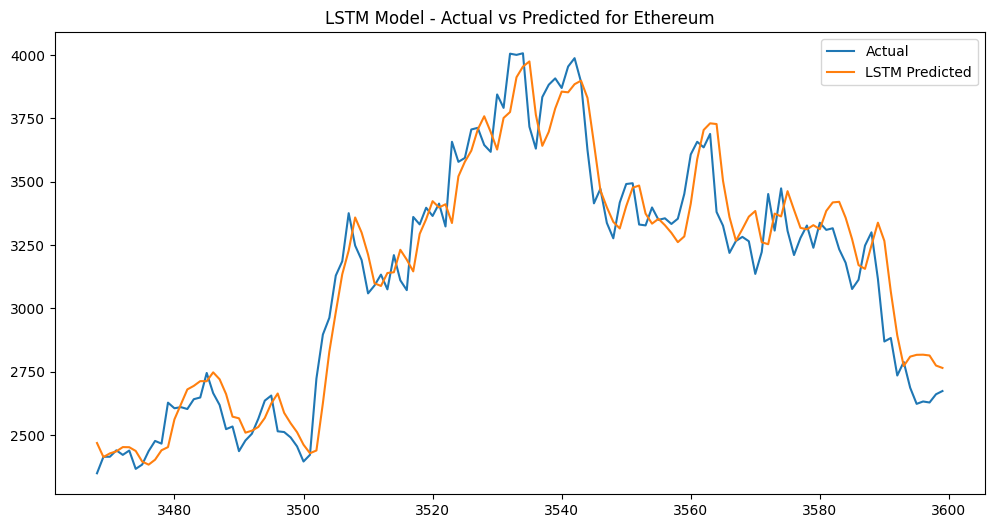

📊 Performance for Ethereum: {'MAE': np.float64(99.7693197370027), 'MSE': np.float64(16152.581374502486), 'RMSE': np.float64(127.09280614772217), 'R-squared': 0.9256504648417807}


In [40]:
scaler = MinMaxScaler(feature_range=(0, 1))
crypto_scaled = scaler.fit_transform(crypto_df[features + [target]])
crypto_scaled = pd.DataFrame(crypto_scaled, columns=features + [target], index=crypto_df.index)

# Train-Test Split
train_size = int(len(crypto_scaled) * 0.8)
train, test = crypto_scaled.iloc[:train_size], crypto_scaled.iloc[train_size:]

# Dynamic Sequence Length Tuning
def create_sequences(data, seq_length):
    x_data, y_data = [], []
    for i in range(seq_length, len(data)):
        x_data.append(data.iloc[i-seq_length:i][features].values)
        y_data.append(data.iloc[i][target])
    return np.array(x_data), np.array(y_data)

# Define Model for Keras Tuner
def build_model(hp):
    sequence_length = hp.Int('sequence_length', min_value=5, max_value=30, step=5)

    x_train, y_train = create_sequences(train, sequence_length)
    x_test, y_test = create_sequences(test, sequence_length)

    model = Sequential([
        Input(shape=(sequence_length, len(features))),
        Bidirectional(LSTM(hp.Int('units_1', min_value=128, max_value=512, step=64), return_sequences=True)),
        Dropout(hp.Float('dropout_1', 0.02, 0.1, step=0.02)),

        LSTM(hp.Int('units_2', min_value=128, max_value=512, step=64), return_sequences=True),
        Dropout(hp.Float('dropout_2', 0.02, 0.1, step=0.02)),

        LSTM(hp.Int('units_3', min_value=128, max_value=512, step=64), return_sequences=False),
        Dropout(hp.Float('dropout_3', 0.02, 0.1, step=0.02)),

        Dense(hp.Int('dense_units', 64, 256, step=64), activation='tanh'),
        Dense(1, activation='linear')
    ])

    # Choose loss function dynamically
    loss_fn = hp.Choice('loss_function', ['mse', 'huber'])

    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.0005, 0.001, 0.002, 0.003])),
                  loss=MeanSquaredError() if loss_fn == 'mse' else Huber(delta=50))  # Huber adjusted for large price range
    return model

# Setup Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=15,  # Increase trials for better optimization
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name=f'crypto_forecasting_{crypto}',
    overwrite=True
)

# Run Hyperparameter Tuning
x_train, y_train = create_sequences(train, 10)  # Temporary value, will be optimized
x_test, y_test = create_sequences(test, 10)

tuner.search(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=32, verbose=1)

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
optimal_sequence_length = best_hps.get('sequence_length')

# Train Final Model with Best Sequence Length
x_train, y_train = create_sequences(train, optimal_sequence_length)
x_test, y_test = create_sequences(test, optimal_sequence_length)

model = build_model(best_hps)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])

# Save Model
model.save(os.path.join("models", f"LSTM_{crypto}.h5"))
print(f"Model saved: models/LSTM_{crypto}.h5")

# Make Predictions
y_pred = model.predict(x_test)
y_pred_rescaled = scaler.inverse_transform(np.concatenate((test.iloc[optimal_sequence_length:][features].values, y_pred), axis=1))[:, -1]
y_test_rescaled = scaler.inverse_transform(np.concatenate((test.iloc[optimal_sequence_length:][features].values, y_test.reshape(-1,1)), axis=1))[:, -1]

# Plot Predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index[optimal_sequence_length:], y_test_rescaled, label="Actual")
plt.plot(test.index[optimal_sequence_length:], y_pred_rescaled, label="LSTM Predicted")
plt.title(f"LSTM Model - Actual vs Predicted for {crypto}")
plt.legend()
plt.show()

# Compute Performance Metrics
performance_metrics = {
    "MAE": mean_absolute_error(y_test_rescaled, y_pred_rescaled),
    "MSE": mean_squared_error(y_test_rescaled, y_pred_rescaled),
    "RMSE": np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled)),
    "R-squared": r2_score(y_test_rescaled, y_pred_rescaled)
}

print(f"📊 Performance for {crypto}:", performance_metrics)

# Save performance
pd.DataFrame([performance_metrics]).to_csv(f"LSTM_Performance_{crypto}.csv", index=False)

In [42]:
import pandas as pd

data_path = "C:/Users/anand/Documents/Capstone Files Dump/Test case 1/separatemodeltraining/cleaned_ethereum_data.csv"
eth_df = pd.read_csv(data_path)

# Convert Timestamp to datetime
eth_df['Timestamp'] = pd.to_datetime(eth_df['Timestamp'], format="%d/%m/%Y", dayfirst=True)
eth_df.set_index('Timestamp', inplace=True)

# Define target variable (Close price)
close_prices = eth_df['Close']

# Define exogenous features
features = ['MACD', 'EMA_7', 'Close_Lag_1']
exog_features = eth_df[features]

# Display first few rows
print(eth_df.head())

               Open     High      Low    Close     VWAP       Volume  Count  \
Timestamp                                                                     
2023-03-08  1561.47  1569.72  1525.01  1532.26  1552.50  12547.52769   9191   
2023-03-09  1532.06  1545.12  1409.64  1438.15  1482.02  39401.65757  16981   
2023-03-10  1437.61  1448.08  1370.00  1430.00  1412.86  74543.58327  25211   
2023-03-11  1430.00  1489.27  1415.01  1483.38  1455.74  64379.38772  32955   
2023-03-12  1483.59  1607.72  1460.43  1591.57  1529.14  59473.31030  26174   

              Crypto  Volatility  Price_Change  ...  Close_Lag_2  Close_Lag_3  \
Timestamp                                       ...                             
2023-03-08  Ethereum       44.71        -29.21  ...      1566.00      1564.50   
2023-03-09  Ethereum      135.48        -94.11  ...      1561.47      1566.00   
2023-03-10  Ethereum       78.08         -8.15  ...      1532.26      1561.47   
2023-03-11  Ethereum       74.26         

In [43]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF Test on Close Price
adf_test = adfuller(close_prices)

print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

if adf_test[1] < 0.05:
    print("✅ Data is stationary, ARIMA can be applied directly (d=0).")
else:
    print("⚠️ Data is non-stationary, differencing is required (d>0).")

ADF Statistic: -1.884685719519033
p-value: 0.3392993702585456
⚠️ Data is non-stationary, differencing is required (d>0).


In [44]:
# Apply first-order differencing if needed
diff_close_prices = close_prices.diff().dropna()

# Perform ADF test again
adf_test_diff = adfuller(diff_close_prices)

print(f"After Differencing - ADF Statistic: {adf_test_diff[0]}")
print(f"After Differencing - p-value: {adf_test_diff[1]}")

if adf_test_diff[1] < 0.05:
    print("✅ Data is now stationary, ARIMA can be applied with d=1.")
else:
    print("⚠️ Still non-stationary, consider d=2.")

After Differencing - ADF Statistic: -27.07812317609813
After Differencing - p-value: 0.0
✅ Data is now stationary, ARIMA can be applied with d=1.


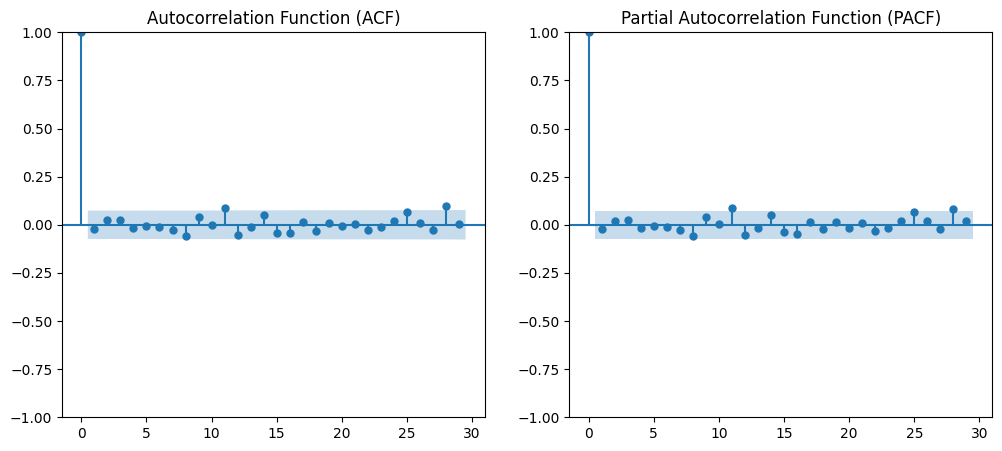

In [45]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF & PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ACF Plot (for q)
plot_acf(diff_close_prices, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

# PACF Plot (for p)
plot_pacf(diff_close_prices, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

In [46]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# Define possible values for p, d, q, P, D, Q
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
P = range(0, 2)
D = range(0, 2)
Q = range(0, 2)
s = [7]  # Weekly seasonality

best_mae = float("inf")
best_params = None
best_model = None

# Grid search over all combinations
for param in itertools.product(p, d, q, P, D, Q, s):
    try:
        model = SARIMAX(close_prices, exog=exog_features, order=param[:3], seasonal_order=param[3:])
        result = model.fit(disp=False)
        
        # Forecast for last 30 days
        forecast = result.forecast(steps=30, exog=exog_features.iloc[-30:])
        
        # Compute MAE
        mae = mean_absolute_error(close_prices[-30:], forecast)
        
        if mae < best_mae:
            best_mae = mae
            best_params = param
            best_model = result
    
    except:
        continue

print(f"✅ Best SARIMAX Parameters: {best_params} with MAE: {best_mae}")

c:\Users\anand\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\anand\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\anand\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\anand\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\anand\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred fr

✅ Best SARIMAX Parameters: (1, 0, 0, 1, 1, 1, 7) with MAE: 54.99427882847132


c:\Users\anand\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [47]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Train the final optimized SARIMAX model
sarimax_final = SARIMAX(close_prices, exog=exog_features,
                        order=(1, 0, 0), seasonal_order=(1, 1, 1, 7))
sarimax_result_final = sarimax_final.fit()

# Print summary of the final model
print(sarimax_result_final.summary())

c:\Users\anand\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\anand\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                  707
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 7)   Log Likelihood               -3603.471
Date:                             Thu, 03 Apr 2025   AIC                           7220.942
Time:                                     10:20:57   BIC                           7252.800
Sample:                                 03-08-2023   HQIC                          7233.257
                                      - 02-11-2025                                         
Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
MACD            4.7867      0.164     29.161      0.000       4.465       5.108
EMA_7           0.7950  

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Forecast next 30 days
sarimax_forecast = sarimax_result_final.forecast(steps=30, exog=exog_features.iloc[-30:])

# Compute Performance Metrics
mae_sarimax = mean_absolute_error(close_prices[-30:], sarimax_forecast)
mse_sarimax = mean_squared_error(close_prices[-30:], sarimax_forecast)
rmse_sarimax = np.sqrt(mse_sarimax)
r2_sarimax = r2_score(close_prices[-30:], sarimax_forecast)

sarimax_performance = {
    "MAE": mae_sarimax,
    "MSE": mse_sarimax,
    "RMSE": rmse_sarimax,
    "R-squared": r2_sarimax
}

print("📊 Final SARIMAX Performance Metrics:", sarimax_performance)


📊 Final SARIMAX Performance Metrics: {'MAE': np.float64(54.99427882847132), 'MSE': np.float64(5273.057588701564), 'RMSE': np.float64(72.61582188959623), 'R-squared': 0.9294836514188723}


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


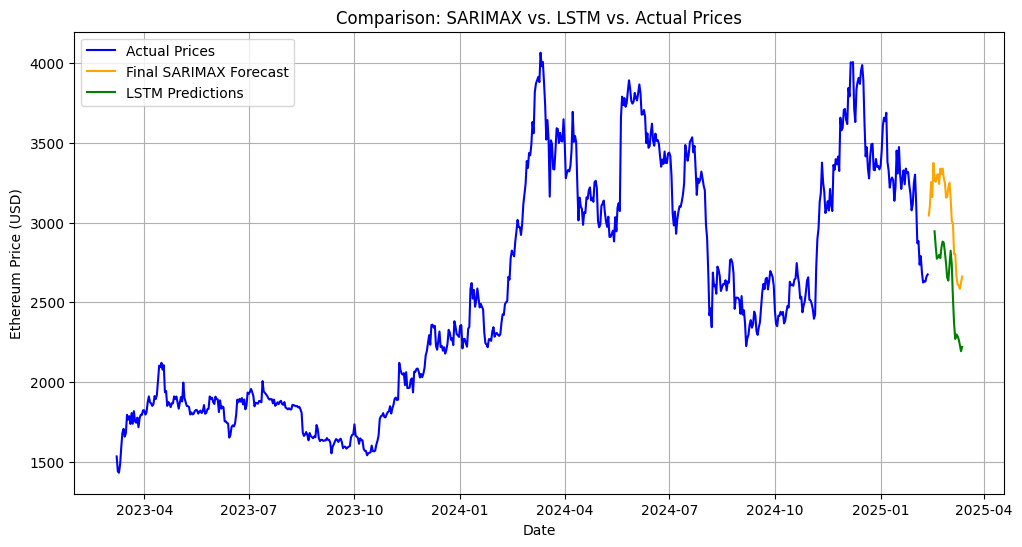

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Load trained LSTM model
lstm_model_path = "C:/Users/anand/Documents/Capstone Files Dump/Test case 1/models/LSTM_Ethereum.h5"
lstm_model = load_model(lstm_model_path)

# Normalize data before feeding into LSTM
features = ['Open', 'High', 'Low', 'Volume', 'VWAP', 'Volatility', 'Price_Change', 'RSI', 'MACD',
            'MA_7', 'MA_14', 'EMA_7', 'EMA_14', 'Rolling_Std_7', 'Rolling_Std_14',
            'Day_of_Week', 'Month', 'Week_of_Year', 'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(eth_df[features])

# Prepare test data for LSTM
look_back = 5
test_scaled = scaled_data[-30:]  # Last 30 days for testing
X_test = []
for i in range(look_back, len(test_scaled)):
    X_test.append(test_scaled[i - look_back:i, :])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], look_back, len(features)))

# LSTM Predictions
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform predictions
lstm_predictions = scaler.inverse_transform(
    np.concatenate([np.zeros((lstm_predictions.shape[0], len(features)-1)), lstm_predictions], axis=1)
)[:, -1]  # Extract only Close Price

# Generate future dates for plotting (30 days ahead)
final_future_dates = pd.date_range(start=close_prices.index[-1], periods=30 + 1, freq='D')[1:]

# Adjust test index for LSTM predictions (aligned with available test data)
lstm_test_index = final_future_dates[look_back:]

# Plot SARIMAX vs. LSTM vs. Actual Prices
plt.figure(figsize=(12, 6))
plt.plot(close_prices.index, close_prices, label="Actual Prices", color='blue')
plt.plot(final_future_dates, sarimax_forecast, label="Final SARIMAX Forecast", color='orange')
plt.plot(lstm_test_index, lstm_predictions, label="LSTM Predictions", color='green')

plt.xlabel('Date')
plt.ylabel('Ethereum Price (USD)')
plt.title("Comparison: SARIMAX vs. LSTM vs. Actual Prices")
plt.legend()
plt.grid()
plt.show()
